<a href="https://colab.research.google.com/github/raduga256/SentimentAnalysisUsingBERT/blob/main/bert_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis

In [6]:
# checking 
!nvidia-smi

Fri Apr  2 15:27:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
 # Installing the Tranformers Library v4.0.1
 !pip -qq install transformers==3.2.0

     |████████████████████████████████| 1.0MB 7.8MB/s 
     |████████████████████████████████| 1.2MB 26.3MB/s 
     |████████████████████████████████| 3.0MB 41.0MB/s 
     |████████████████████████████████| 890kB 55.9MB/s 


In [8]:
# Installing a specific version of PyTorch because colab default is 1.4
# !pip install --no-cache-dir torch==1.6.0

In [11]:
# Installing PyTorch Library v1.2.0
!pip install -qq pytorch-lightning   #quite mode

     |████████████████████████████████| 839kB 8.3MB/s 
     |████████████████████████████████| 829kB 19.2MB/s 
     |████████████████████████████████| 276kB 48.0MB/s 
     |████████████████████████████████| 184kB 49.0MB/s 
     |████████████████████████████████| 112kB 48.6MB/s 
     |████████████████████████████████| 1.3MB 35.2MB/s 
     |████████████████████████████████| 143kB 57.7MB/s 
     |████████████████████████████████| 296kB 58.5MB/s 


In [5]:
# checking for the installed pytorch version
print(torch.__version__)

1.8.1+cu101


In [ ]:
# Intalling torchtext version compatible to installed pytorch v1.6
# !pip install -U torchtext==0.8.0

In [9]:
!pip list | grep torchtext   # What version do you have for torchtext?

torchtext                     0.9.1         


In [12]:
# Import Some Libraries

import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
# from transformers.optimization import get_linear_scheduler_with_warmup
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import auroc

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# Seeding the Random Generator and the Torch Generator


In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ("#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF")
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) # it is not the best way to do but it will work for this case



In [15]:
# Downoad the data set
# dataset_url = "https://raw.githubusercontent.com/iampukar/toxic-comments-classification/master/sample_submission.csv"
# df1 = pd.read_csv(dataset_url) this dataset doesn't contain original toxic comments so i have ignored it for alternative similar

"""These are google play apps reviews. """
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
# Dataset is now stored in a Pandas Dataframe

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.0MB/s]


In [16]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [17]:
# Checking out the dataset shape
df.shape

(15746, 11)

In [18]:
# We have about 16k examples. Let’s check for missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Review Count')

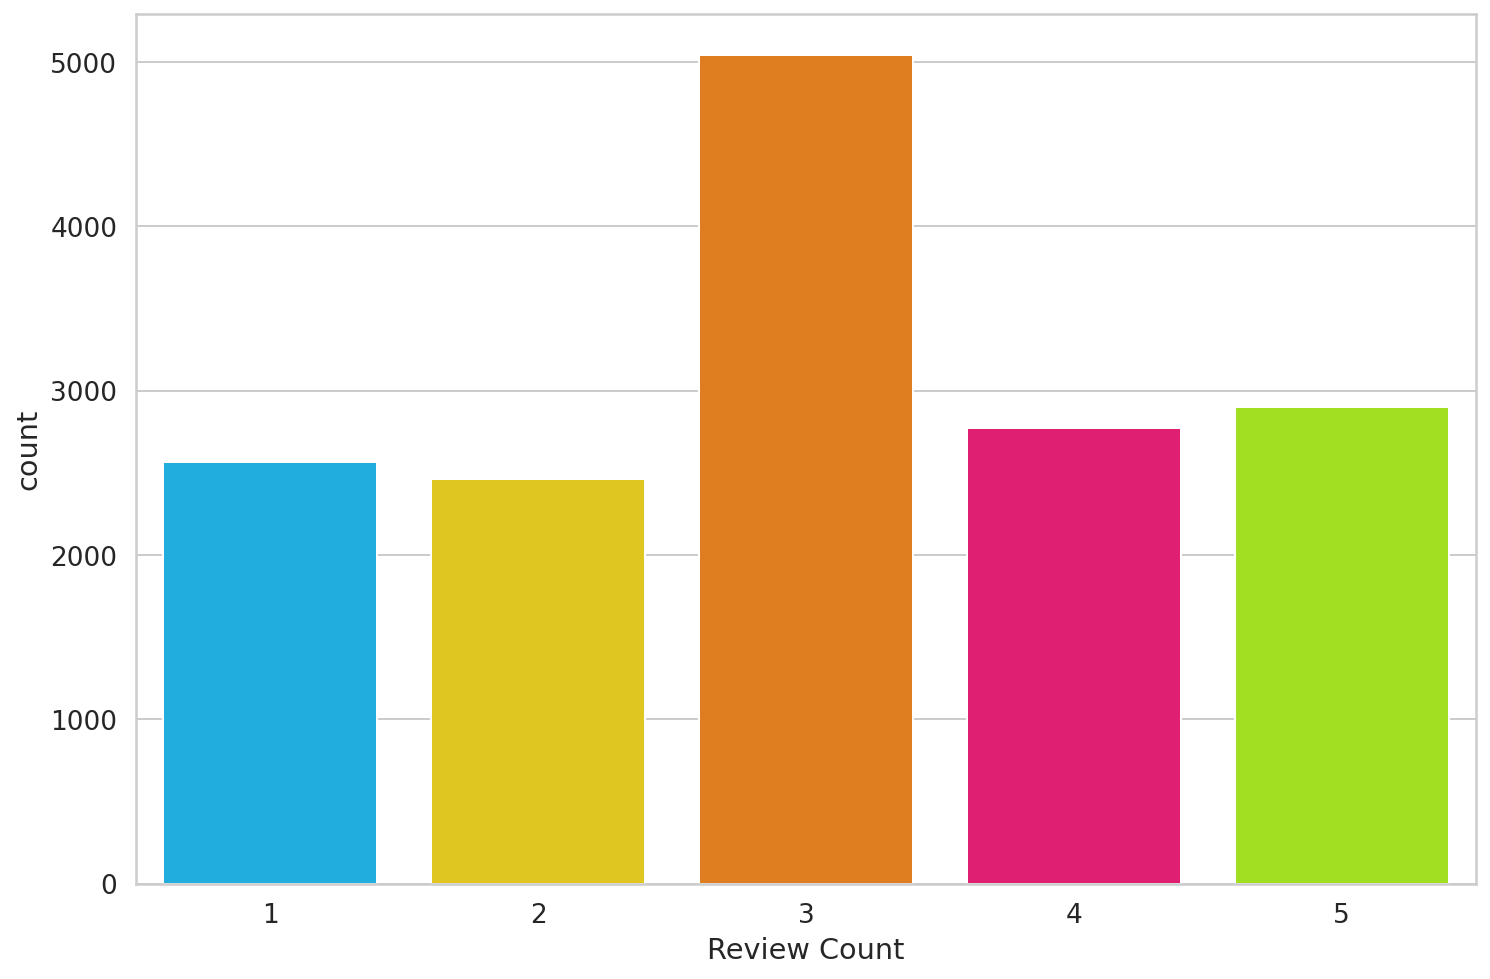

In [19]:
# Great, no missing values in the score and review texts! Do we have class imbalance?
sns.countplot(df.score)
plt.xlabel('Review Count')

That’s hugely imbalanced, but it’s okay. We’re going to convert the dataset into negative, neutral and positive sentiment:

In [20]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
      return 1
  else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [21]:
# class labels
class_labels = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


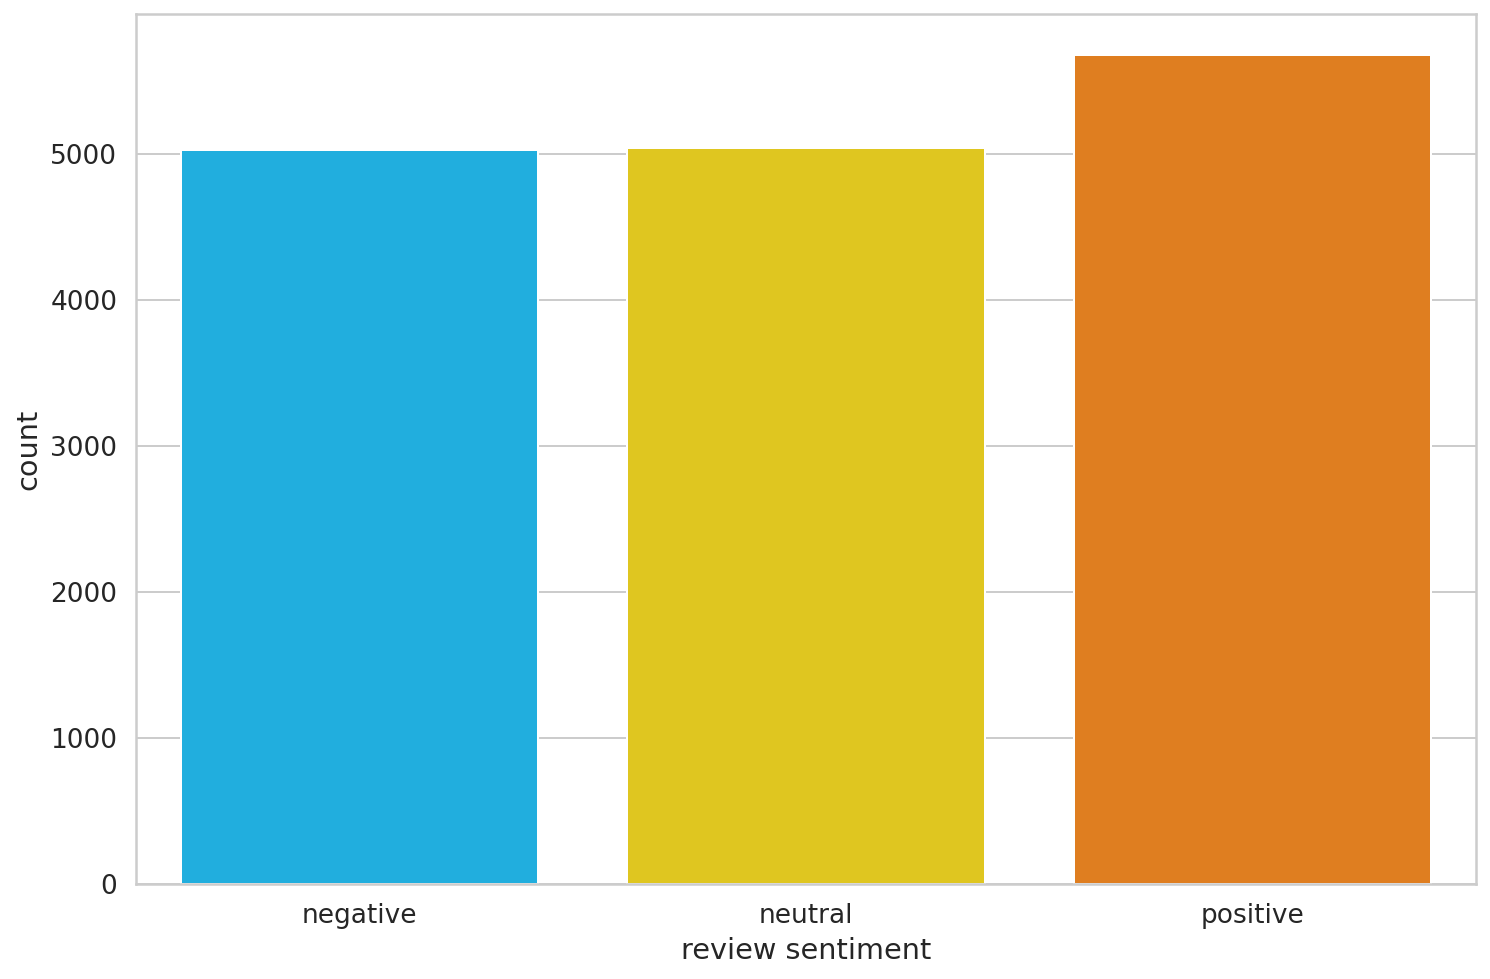

In [22]:
#  plot
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_labels);

## Data Preprocessing

You might already know that Machine Learning models don’t work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

Add special tokens to separate sentences and do classification
Pass sequences of constant length (introduce padding)
Create array of 0s (pad token) and 1s (real token) called attention mask
The Transformers library provides (you’ve guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

In [23]:
# Prebuilt tokenizer
#You can use a cased and uncased version of BERT and tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [24]:
# Let's  load a pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [25]:
# We’ll use this text to understand the tokenization process:

sample_txt = "When was I last outside? I am stuck at home for two weeks"

In [26]:
# Some basic operations can convert the text to tokens and tokens to unique integers (ids)
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for two weeks
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', 'two', 'weeks']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 1160, 2277]


## Special Tokens

In [ ]:
# -marker for endings of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# we must add this token to the start of each sentence, so BERT knows we’re doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work above can be done using the encode_plus() method illustrated below:

In [69]:
#  encode_plus()

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=True,
    #truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding = True, # pad_to_max_length=True, is deprecated
    return_attention_mask=True,
    return_tensors='pt'  # Return PyTorch tensors   
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [70]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

16


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111, 1160, 2277,  102])

In [38]:
# The attention mask has the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'] 

16


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [30]:
# We can inverse the tokenization to have a look at the special tokens:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 'two',
 'weeks',
 '[SEP]']

## Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

In [ ]:
token_lens = []

for txt in df['content']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Text(0.5, 0, 'Token Count')

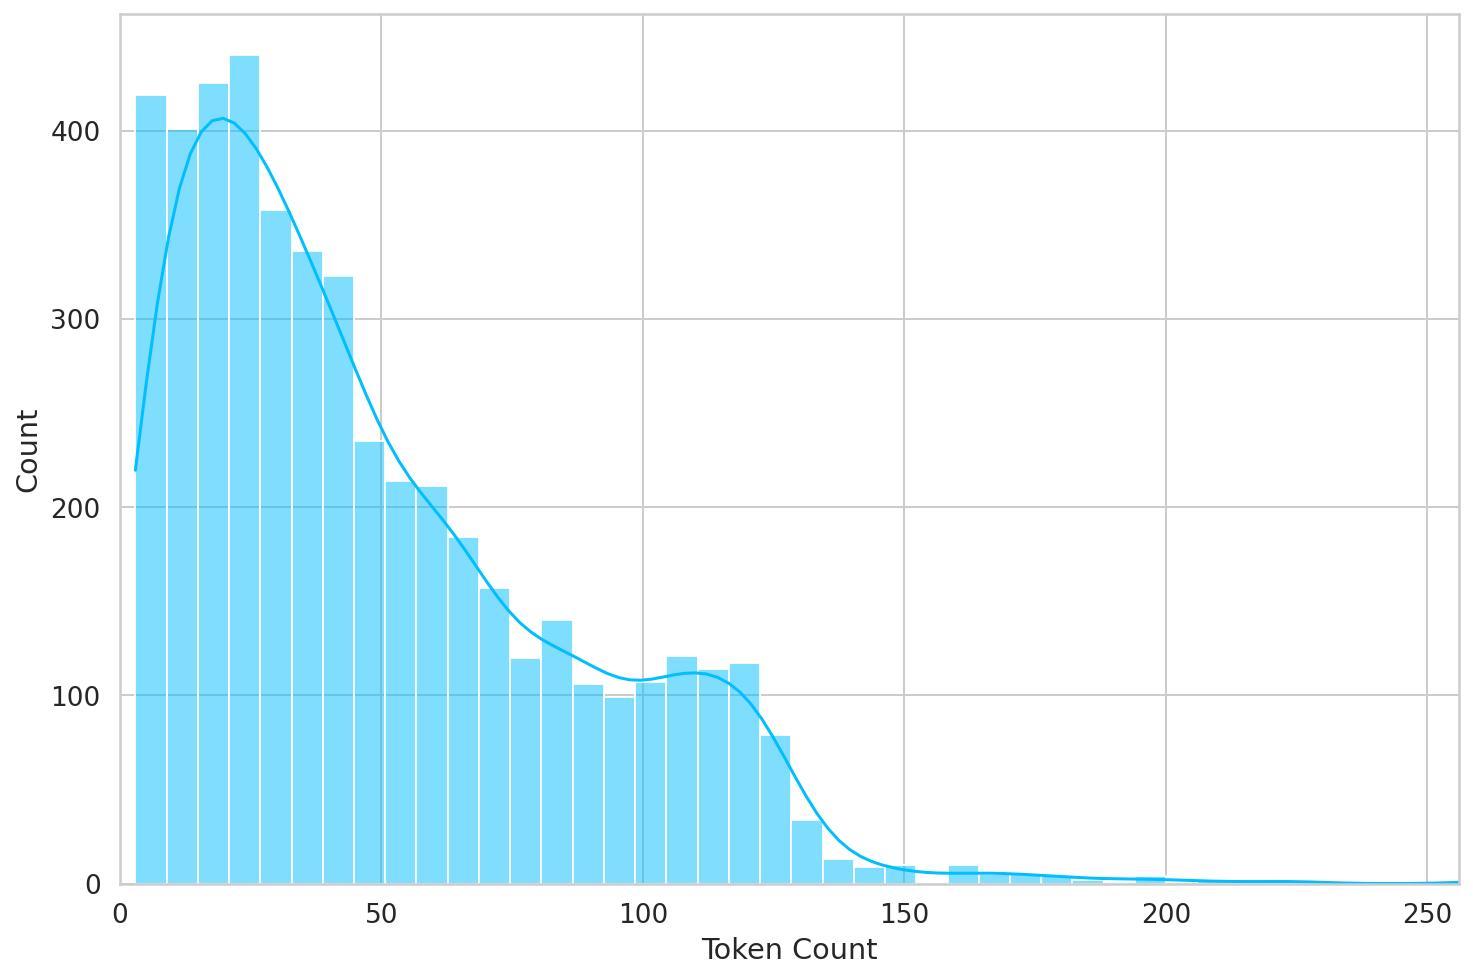

In [42]:
# plot the distributions
sns.histplot(token_lens, kde=True)
plt.xlim([0, 256])
plt.xlabel('Token Count')

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160

In [53]:
MAX_LEN = 160

We have all buildings blocks required to create a PyTorch dataset. Let's do it

In [77]:
class GPReviewDataset(Dataset):
  def __ini__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    #encoding for tokenizer
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=160, #self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }



The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it’ll be easier to evaluate the predictions from our model. Let’s split the data:

In [78]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

We also need to create a couple of data loaders. Here is a helper function to do it:


In [79]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [56]:
# Let’s have a look at an example batch from our training data loader:
data = next(iter(train_data_loader))
data.keys()